In [1]:
import os
import re 


Testing Regular expressions

In [2]:
text = "Hello, world. This, is a test."
result1 = text.split()
result2 = re.split(r'\s', text)
result3 = re.split(r'(\s)', text)

result1, result2, result3 

(['Hello,', 'world.', 'This,', 'is', 'a', 'test.'],
 ['Hello,', 'world.', 'This,', 'is', 'a', 'test.'],
 ['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.'])

In [3]:
  
result = re.split(r'([.,]|\s)', text)
print(result)
# Works fine but also includes whitespaces. We want to remove it.

# The following line discards paranthesis which causes the result to discard all the matched symbols including '.' , ','   and ' '
result1 = re.split(r'[.,]|\s', text)
print(result1)

# So, we need to manually remove whitespaces from the list
formatted_result = [item for item in result if item.strip()]
formatted_result

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']
['Hello', '', 'world', '', 'This', '', 'is', 'a', 'test', '']


['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']

Adding other punctuations as well

In [4]:
text = "Hello, world. Is this-- a test?"
result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
result 

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']

In [5]:
with open("data/the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

Applying it to entire text we have.

## Custom Vocabulary and tokenizer

In [6]:
class Vocabulary:

    def __init__(self, raw_text =None, file_path = None):
        self.file_path = file_path
        self.raw_text = raw_text
        self.preprocessed_tokens = []

        if not any((raw_text, file_path)):
            raise ValueError("Either raw_text or file_path must be provided.")
        # load text from file if a path is provided
        if self.file_path and not self.raw_text:
            self.raw_text = self.get_text()
        
        if self.raw_text:
            self.preprocess_text()
            self.build_vocab()

    def get_text(self):

        if not self.file_path:
            raise ValueError("File path is not provided.")
        
        base_dir = os.getcwd()
        full_path = os.path.join(base_dir, self.file_path)
        with open(full_path, "r", encoding = "utf-8") as f:
            raw_text = f.read()

        return raw_text

    def preprocess_text(self):
        """Tokenize and clean the raw text."""
        # Tokenize the raw text using the provided regex
        if not self.raw_text:
            raise ValueError("No raw text available to preprocess.")
        tokens = re.split(r'([,.:;?_!"()\']|--|\s)', self.raw_text)
        self.preprocessed_tokens = [item.strip() for item in tokens if item.strip()]
    
    def build_vocab(self):
        all_tokens = sorted(set(self.preprocessed_tokens))
        all_tokens.extend(["<|endoftext|>", "<|unk|>"])
        self.token_to_int = {}
        self.int_to_token = {}
        
        self.token_to_int = {token:integer for integer, token in enumerate(all_tokens)}
        self.int_to_token = {integer:token for token, integer in self.token_to_int.items()}

    @classmethod
    def from_string(cls, text):
        return cls(raw_text = text)
    
    @classmethod
    def from_list(cls, text_list):
        combined_text = "".join(text_list)
        return cls(raw_text = combined_text)

In [7]:
verdict_vocab = Vocabulary(file_path="data/the-verdict.txt")

In [8]:
len(verdict_vocab.token_to_int)

1132

In [9]:
class Tokenizer:
    
    def __init__(self, vocab:Vocabulary):
        '''
        Initialize the vocabulary 
        '''
        self.vocab = vocab
        self.str_to_int = self.vocab.token_to_int
        self.int_to_str = self.vocab.int_to_token

    def encode(self, text):
        ''' 
            Encode a passed text as per the vocabulary and convert text to token ids
        '''
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        preprocessed = [item if item in self.str_to_int 
                        else "<|unk|>" for item in preprocessed]
        ids = [self.str_to_int[token] for token in preprocessed]
        return ids
    
    def decode(self, ids):
        '''
            Decode a given token IDs to token and join it to text 
        '''
        text = " ".join([self.int_to_str[i] for i in ids])
        '''
        For each ID, it uses the int_to_str dictionary (which maps integer IDs to tokens) to retrieve 
        the corresponding token.
        Finally, it joins all the retrieved tokens with a space character (" ") 
        to form a preliminary text strin 
        '''
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [10]:
text ='Hello! Hi Bye Bye.' 
tokenizer = Tokenizer(verdict_vocab)
encoded_ids = tokenizer.encode(text)
print(encoded_ids)
decoded_text = tokenizer.decode(encoded_ids)
decoded_text

[1131, 0, 1131, 1131, 1131, 7]


'<|unk|>! <|unk|> <|unk|> <|unk|>.'

In [11]:
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
print(text)

print(tokenizer.encode(text))

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.
[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]


## Byte-Pair Encoding

Byte-Pair encoding is achieved using `tiktoken` library. This enables the LLM to process any unseen or gibberish word without the need of `unk` token. 

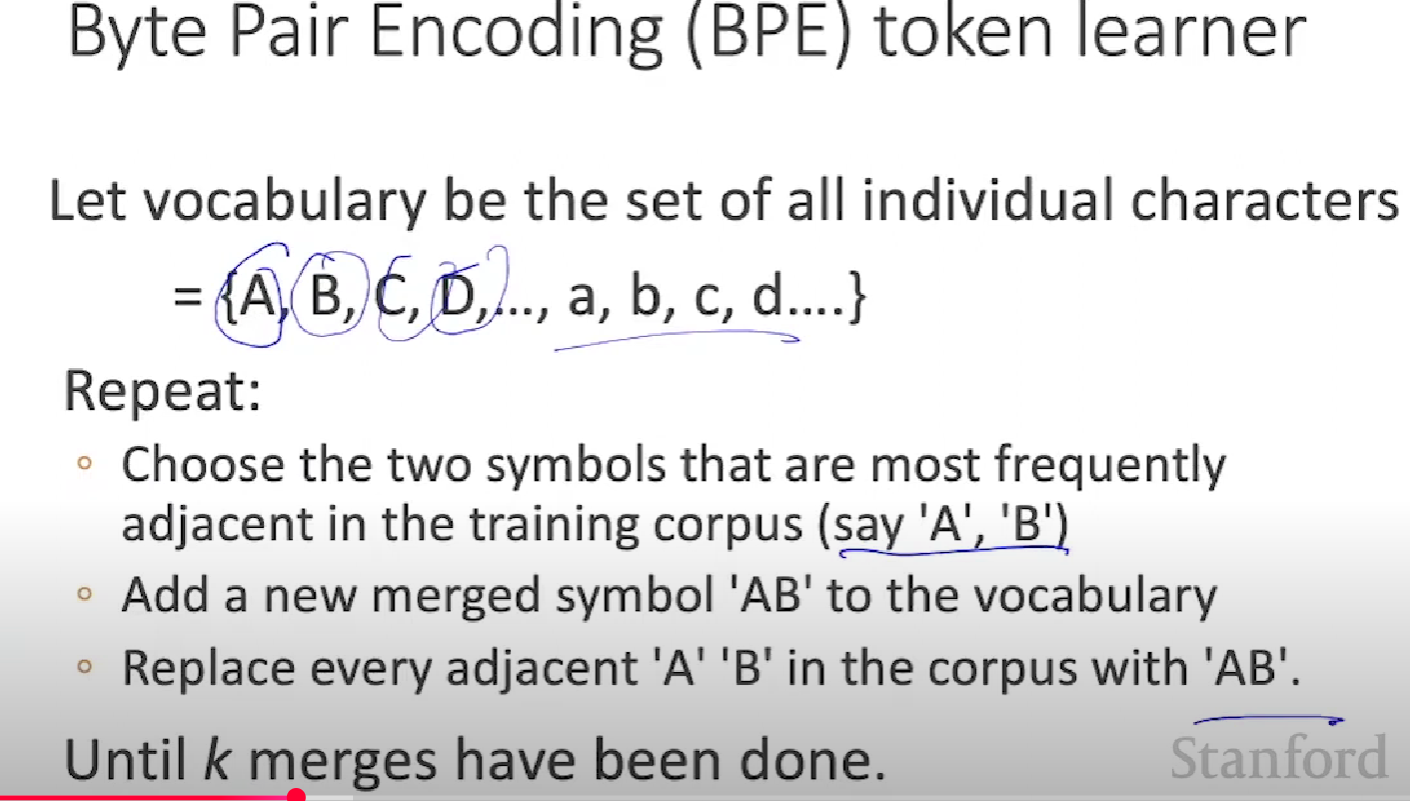

In [12]:
import tiktoken 

tokenizer = tiktoken.get_encoding("gpt2")
text = (
 "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
 "of someunknownPlace."
)
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)
strings = tokenizer.decode(integers)
print(strings)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]
Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


In [13]:
text = "Akwirw ier" 
ids = tokenizer.encode(text)
print(tokenizer.decode(ids))

Akwirw ier


## Data sampling with a sliding window

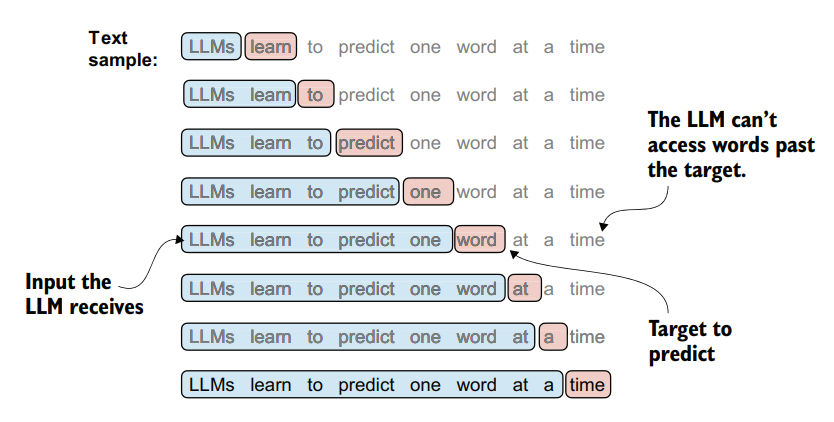

In [14]:
enc_text = tokenizer.encode(raw_text)
len(enc_text)

5145

In [15]:
enc_sample = enc_text[:50]

### Create the input–target pairs for the next word prediction task 
Create two variables, x and y, where x contains the input okens and y contains the targets, which are the inputs shifted by 1

In [16]:
context_size = 4
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

I ---->  H
I H ----> AD
I HAD ---->  always
I HAD always ---->  thought


## Make input and target tensors 
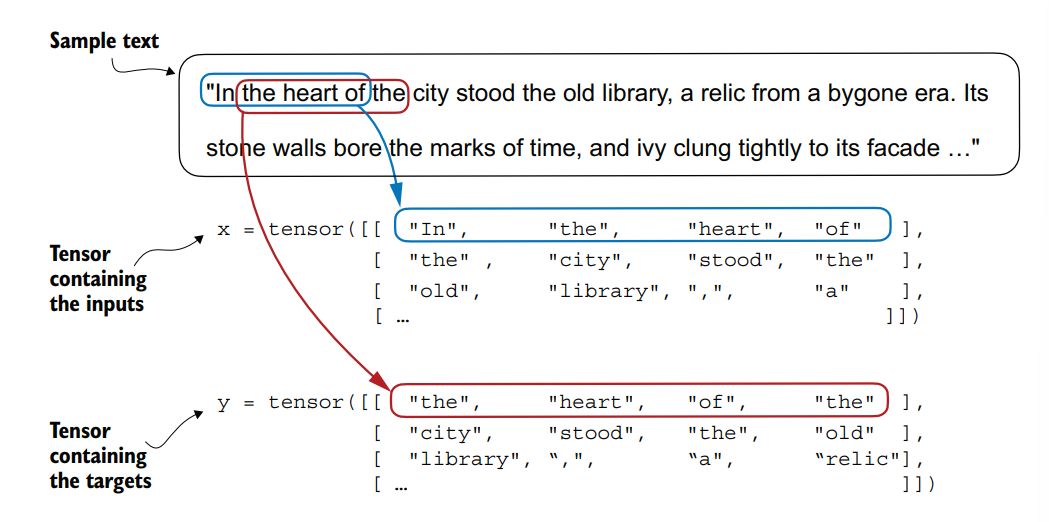

While the figure shows the tokens in string format for illustration purposes, the code implementation will operate on token IDs
<!-- directly since the encode method of the BPE tokenizer performs both tokenization
and conversion into token IDs as a single step. -->

In [17]:
import torch 
from torch.utils.data import Dataset, DataLoader 


## Create the Dataset and the Dataloader
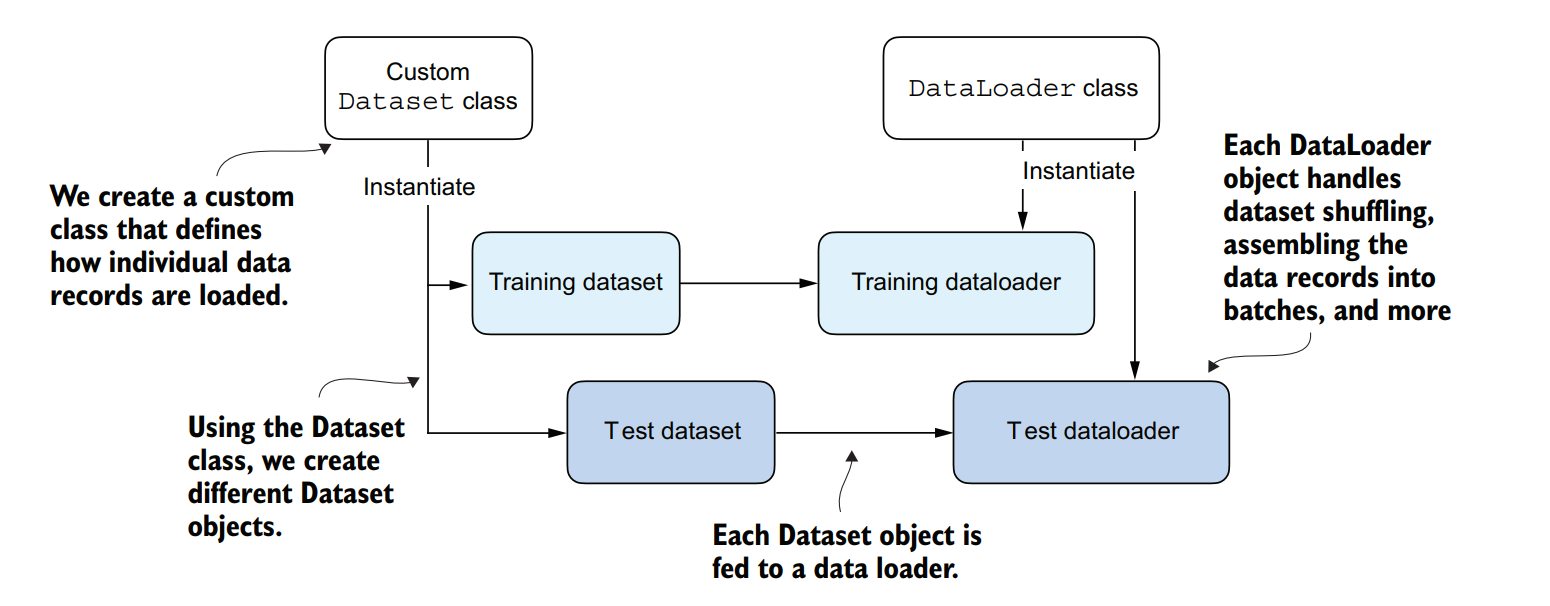

In [18]:
class GPTDatasetV1(Dataset):

    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i: i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]

            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [19]:
'''
A more efficient implementation 
'''

# class GPTDatasetV2(Dataset):
#     def __init__(self, txt, tokenizer, max_length, stride):
#         self.token_ids = tokenizer.encode(txt)
#         self.max_length = max_length
#         self.stride = stride
#         self.num_samples = (len(self.token_ids) - max_length) // stride + 1

#     def __len__(self):
#         return self.num_samples

#     def __getitem__(self, idx):
#         start_idx = idx * self.stride
#         input_chunk = self.token_ids[start_idx: start_idx + self.max_length]
#         target_chunk = self.token_ids[start_idx + 1: start_idx + self.max_length + 1]
#         return torch.tensor(input_chunk), torch.tensor(target_chunk)


'\nA more efficient implementation \n'

### Significance of `num_workers`
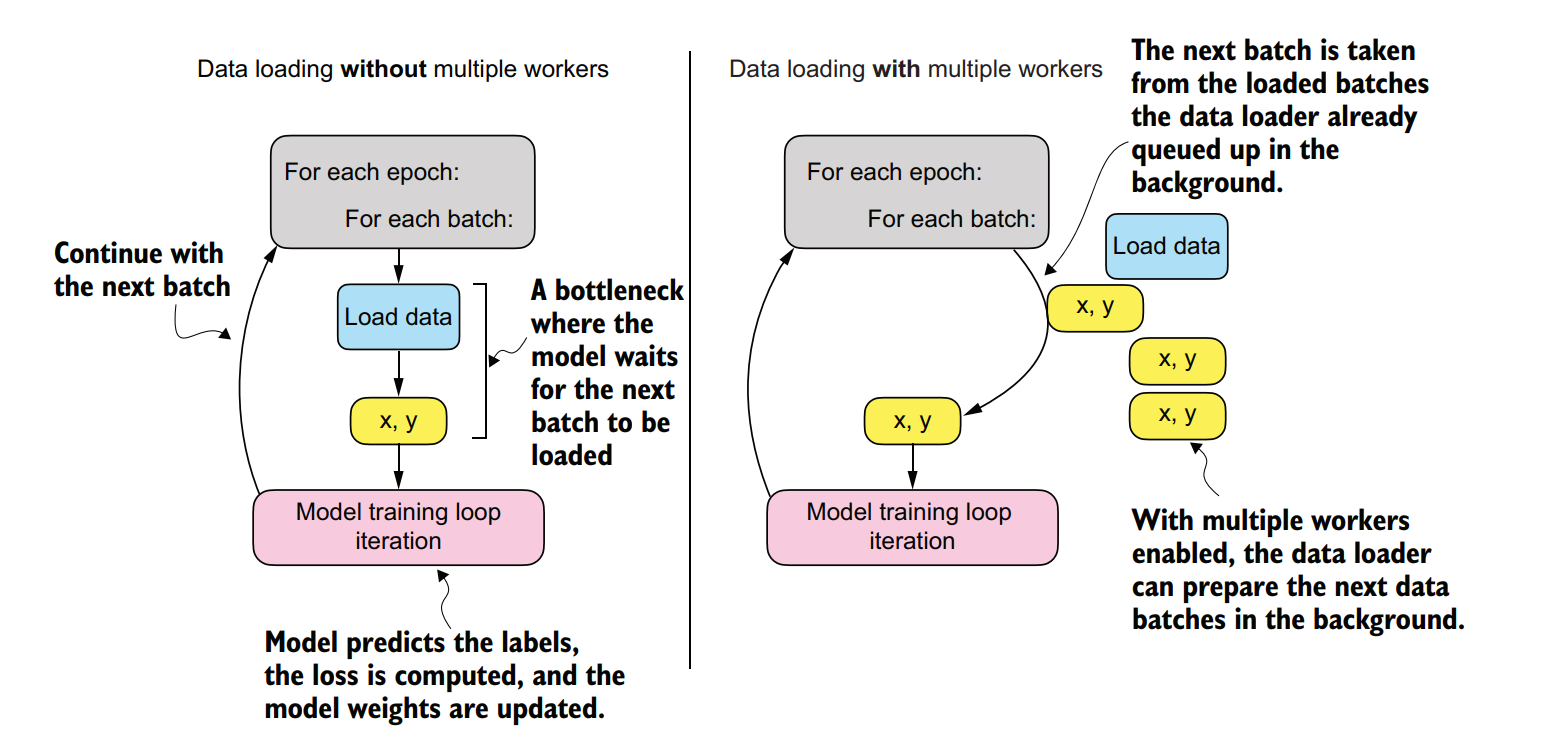
Loading data without multiple workers (setting num_workers=0) will create a data loading 
bottleneck where the model sits idle until the next batch is loaded (left). If multiple workers are enabled, the data 
loader can queue up the next batch in the background (right).

In [20]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
 stride=128, shuffle=True, drop_last=True,
 num_workers=1):
    
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size,
        shuffle = shuffle,
        drop_last = drop_last,
        num_workers = num_workers
    )

    return dataloader

### DataLoader in action!

In [21]:
dataloader = create_dataloader_v1(
 raw_text, batch_size=1, max_length=4, stride=1, shuffle=False)

data_iter = iter(dataloader)
for i in range(3):
    inputs, targets = next(data_iter)
    print("Inputs:\n", inputs)
    print("\nTargets:\n", targets)
    

Inputs:
 tensor([[  40,  367, 2885, 1464]])

Targets:
 tensor([[ 367, 2885, 1464, 1807]])
Inputs:
 tensor([[ 367, 2885, 1464, 1807]])

Targets:
 tensor([[2885, 1464, 1807, 3619]])
Inputs:
 tensor([[2885, 1464, 1807, 3619]])

Targets:
 tensor([[1464, 1807, 3619,  402]])


In [22]:
dataloader = create_dataloader_v1(
 raw_text, batch_size=2, max_length=6, stride=1, shuffle=False)

data_iter = iter(dataloader)
for i in range(3):
    inputs, targets = next(data_iter)
    print("Inputs:\n", inputs)
    print("\nTargets:\n", targets)

Inputs:
 tensor([[  40,  367, 2885, 1464, 1807, 3619],
        [ 367, 2885, 1464, 1807, 3619,  402]])

Targets:
 tensor([[ 367, 2885, 1464, 1807, 3619,  402],
        [2885, 1464, 1807, 3619,  402,  271]])
Inputs:
 tensor([[ 2885,  1464,  1807,  3619,   402,   271],
        [ 1464,  1807,  3619,   402,   271, 10899]])

Targets:
 tensor([[ 1464,  1807,  3619,   402,   271, 10899],
        [ 1807,  3619,   402,   271, 10899,  2138]])
Inputs:
 tensor([[ 1807,  3619,   402,   271, 10899,  2138],
        [ 3619,   402,   271, 10899,  2138,   257]])

Targets:
 tensor([[ 3619,   402,   271, 10899,  2138,   257],
        [  402,   271, 10899,  2138,   257,  7026]])


## Creating token embeddings
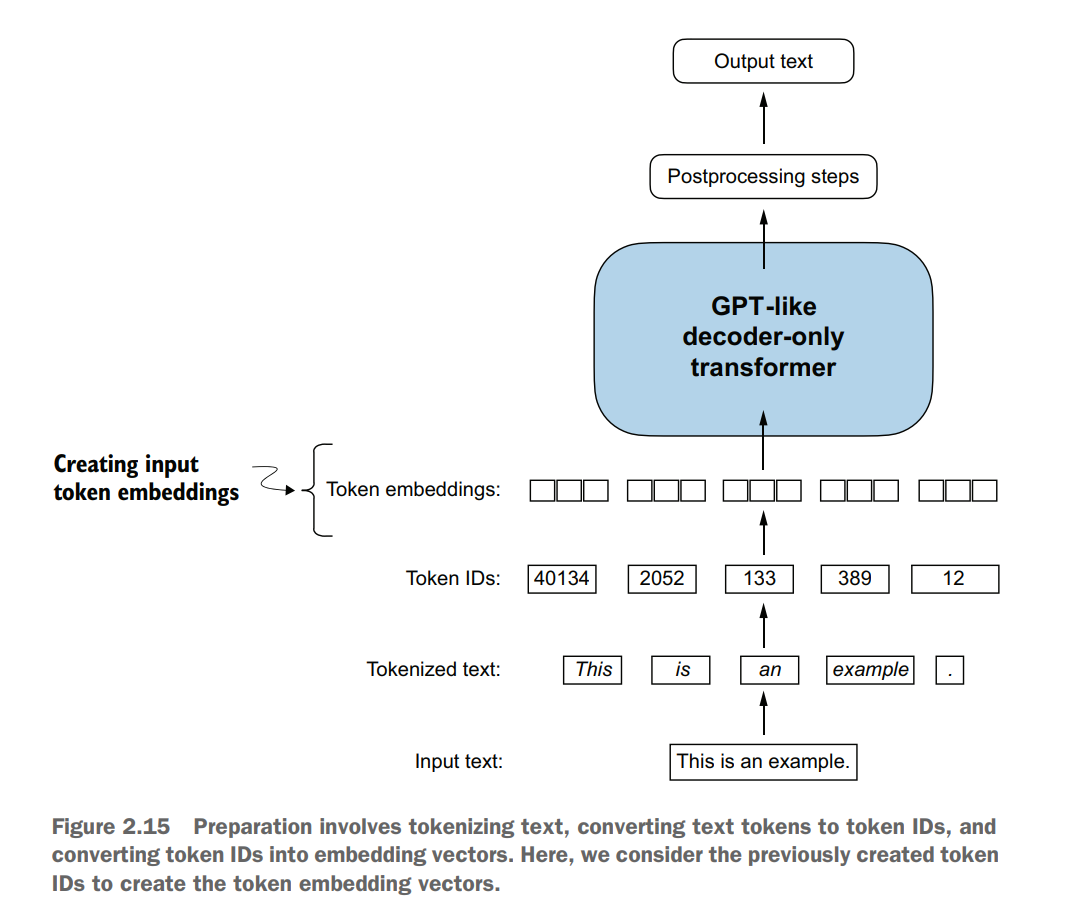

In [23]:
# A simple example with 4 token IDs

input_ids = torch.tensor([2, 3, 5, 1])

vocab_size = 6   # since largest id is 5 
output_dim = 3
torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


In [24]:
# The output corresponds to a manual lookup function
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


## Encoding Word positions
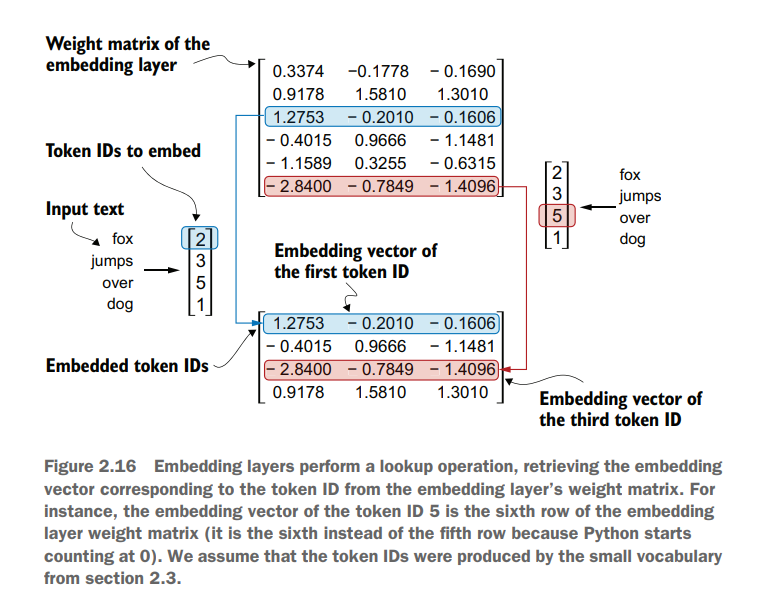

## Relative Positional Embeddings vs Absolute Positional Embeddings

### Absolute Positional Embeddings
Absolute embeddings explicitly encode the position of each token in a sequence. They are fixed embeddings assigned to each position in the input sequence.
* Representation: Each position in the sequence is represented by a unique embedding vector.
* Implementation: Commonly implemented as learnable position embeddings (vectors) or sinusoidal functions (as in the original Transformer paper).
    * Learnable: The embeddings are trainable and initialized randomly.
    * Sinusoidal: The embeddings are computed using fixed sinusoidal functions of different frequencies, ensuring each position has a unique representation
* Positional Dependency: Absolute embeddings encode positions independently of the tokens or their relationships.

An example is Positional Encoding

### Positional Encoding
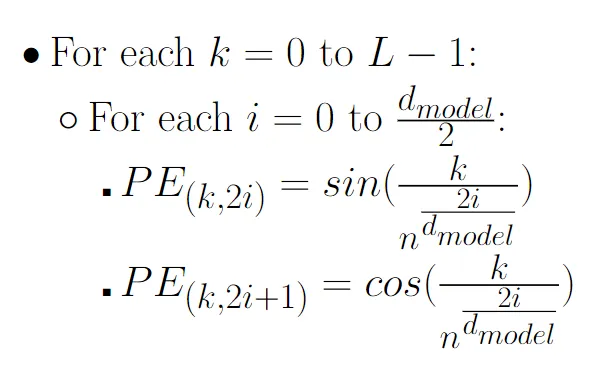

### Relative Positional Embeddings
Relative embeddings focus on encoding the relative positions between tokens in a sequence rather than their absolute positions.
* Representation: Encodes the difference between positions of two tokens in the sequence.
* Implementation: Often incorporated directly into the attention mechanism.
* Positional Dependency: Focuses on the positional relationship between tokens.

#### An illustrative example

In relative positional encoding, we do not only randomly initialize the embeddings for each position. Instead, we create a **pair-wise embedding matrix** of size (T, 2 * T — 1), where the row-index represents the word we are interested in, and the col-index represents the positional distance from the word (indicated by row-index) to all the other words (indicated by col-index) that can be before and after it.


Differences can range from -(T-1) to +(T-1):
So, Formula to Map Relative Distance to Index:
  **Index = Relative Distance + (T-1)**


If we have a fixed window (from word_i-4 to word_i+4), pair wise distance matrix is:
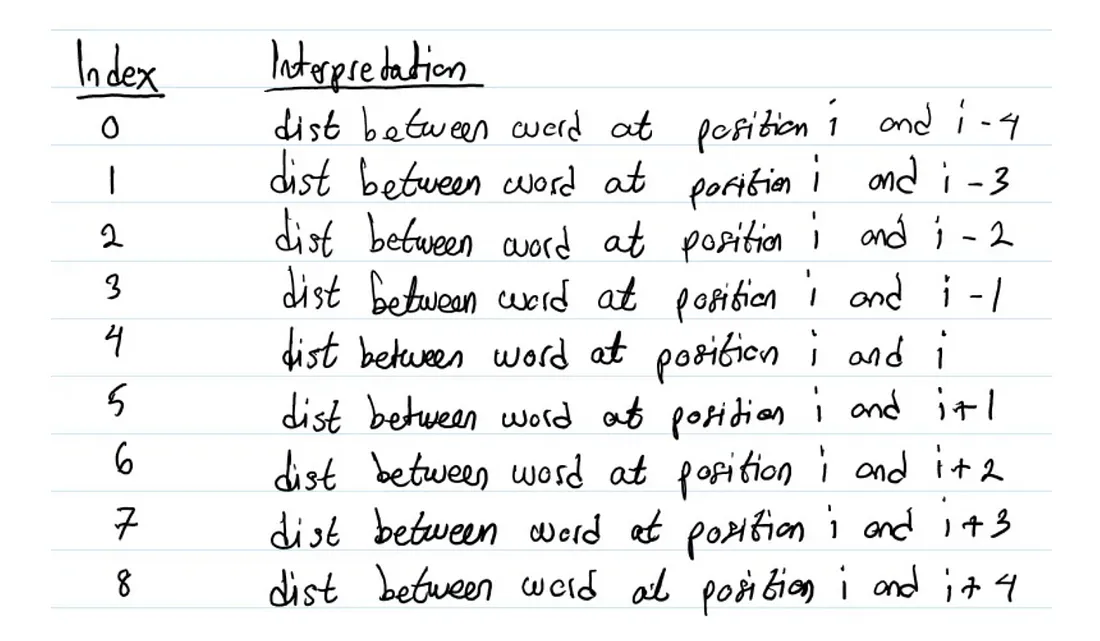

#### HOW?
Example: Sentence [‘this’, ‘is’, ‘very’, ‘awesome’, ‘too’]
* Length of the sentence (T = 5)
* Relative distances:
    -4, -3, -2, -1, 0, +1, +2, +3, +4

* Indices in the pairwise matrix:
    0,1,2,3,4,5,6,7,8

So, for the word `this(word1)`:
Relative distances to words within the window:
 1. this (itself) : 0 -> index 4
 2. is : +1 -> index 5
 3. very : +2 -> index 6
 4. awesome : +3 -> index 7
 5. to : +4 -> index 8

 So, the relative embedding = [4,5,6,7,8]

For the word `very(word3)`
Relative distances to words within the window:
 1. this: -2 -> index 2
 2. is: -1 -> index 3
 3. very : 0 -> index 4
 4. awesome : +1 -> index 5
 5. too: +2 -> index 6
 
 So, the relative embedding = [2,3,4,5,6]

## Making embedding for all tokens

In [25]:
# Instantiating the embedding layer

vocab_size = 50257
output_dim = 256

tokeen_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

Viewing the initial size of the sample of dataloader

In [26]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length, stride = max_length, shuffle = False
)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)


Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


After creating the token embeddings the size is now:

In [27]:
token_embeddings = tokeen_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


In [30]:
token_embeddings[0]

tensor([[ 0.4913,  1.1239,  1.4588,  ..., -0.3995, -1.8735, -0.1445],
        [ 0.4481,  0.2536, -0.2655,  ...,  0.4997, -1.1991, -1.1844],
        [-0.2507, -0.0546,  0.6687,  ...,  0.9618,  2.3737, -0.0528],
        [ 0.9457,  0.8657,  1.6191,  ..., -0.4544, -0.7460,  0.3483]],
       grad_fn=<SelectBackward0>)

### Creating Absolute Positional embedding 

In [28]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


We can now add these directly to the token embeddings, where PyTorch will add
the 4 × 256–dimensional pos_embeddings tensor to each 4 × 256–dimensional token
embedding tensor in each of the eight batches:

In [31]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])
